In [32]:
# 1: 데이터 로드 및 전처리
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 

df = pd.read_csv('../data/raw/BankChurners.csv')
df = df.copy()
df['Attrition_Binary'] = (df['Attrition_Flag'] == 'Attrited Customer').astype(int)

drop_cols = ['CLIENTNUM', 'Attrition_Flag', 
             "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2", 
             "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1"] 
df = df.drop(columns=drop_cols)
print(df.shape)

(10127, 20)


In [33]:
# 2: Feature 생성
df["Avg_Transaction_Amount"] = df["Total_Trans_Amt"] / (df["Total_Trans_Ct"] + 1)
df["Credit_Utilization"] = df["Credit_Limit"] / (df["Months_on_book"] + 1)
print(df.shape)

(10127, 22)


In [34]:
# 3: 전처리 파이프라인 정의
X = df.drop('Attrition_Binary', axis=1)
y = df['Attrition_Binary']

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist() 

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

In [35]:
# 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (8101, 21), Test set: (2026, 21)


In [36]:
# 5: Random Forest GridSearch
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, recall_score, f1_score

print("Random Forest GridSearch")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__class_weight': ['balanced', None]
}

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

best_rf_pipeline = rf_grid.best_estimator_
best_rf_model = rf_grid.best_estimator_.named_steps['rf']

print("Best RF Params:", rf_grid.best_params_)
print("Best CV ROC-AUC Score:", rf_grid.best_score_)

Random Forest GridSearch
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best RF Params: {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best CV ROC-AUC Score: 0.9899056883633373


In [48]:
# 6: XGBoost GridSearch
from xgboost import XGBClassifier
from collections import Counter

print("XGBoost GridSearch")

balanced_xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
])

class_counts = Counter(y_train)
scale_pos_weight_value = class_counts[0] / class_counts[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

xgb_params = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [5, 7],
    'xgb__scale_pos_weight': [scale_pos_weight_value, 
                               scale_pos_weight_value * 1.2, 
                               scale_pos_weight_value * 0.8]
}

xgb_grid = GridSearchCV(
    estimator=balanced_xgb_model,
    param_grid=xgb_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

best_xgb_pipeline = xgb_grid.best_estimator_
best_xgb_model = xgb_grid.best_estimator_.named_steps['xgb']

print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB CV ROC-AUC Score:", xgb_grid.best_score_)

XGBoost GridSearch
Calculated scale_pos_weight: 5.22
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best XGB Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 6.266359447004608}
Best XGB CV ROC-AUC Score: 0.9926389868210098


In [38]:
# 7: LightGBM GridSearch 
from lightgbm import LGBMClassifier

print("LightGBM GridSearch")

lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', LGBMClassifier(random_state=42, verbose=-1))
])

lgbm_params = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__learning_rate': [0.05, 0.1],
    'lgbm__max_depth': [5, 7, -1],
    'lgbm__num_leaves': [31, 50],
    'lgbm__scale_pos_weight': [scale_pos_weight_value, 
                                scale_pos_weight_value * 1.2, 
                                scale_pos_weight_value * 0.8]
}

lgbm_grid = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

lgbm_grid.fit(X_train, y_train)

best_lgbm_pipeline = lgbm_grid.best_estimator_
best_lgbm_model = lgbm_grid.best_estimator_.named_steps['lgbm']

print("Best LightGBM Params:", lgbm_grid.best_params_)
print("BestLightGBM CV ROC-AUC Score:", lgbm_grid.best_score_)

LightGBM GridSearch
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

Best LightGBM Params: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__n_estimators': 200, 'lgbm__num_leaves': 31, 'lgbm__scale_pos_weight': 5.221966205837173}
BestLightGBM CV ROC-AUC Score: 0.9935982096393273


In [49]:
# 8: 개별 모델 성능 평가
print("개별 모델 테스트 성능 평가")

# RF 평가
y_pred_rf = best_rf_pipeline.predict(X_test)
y_proba_rf = best_rf_pipeline.predict_proba(X_test)[:, 1]
acc_rf = accuracy_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("\n Random Forest:")
print(f"  Accuracy: {acc_rf:.4f}")
print(f"  ROC-AUC:  {roc_rf:.4f}")
print(f"  Recall:  {recall_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")

# XGB 평가
y_pred_xgb = best_xgb_pipeline.predict(X_test)
y_proba_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]
acc_xgb = accuracy_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_proba_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("\n XGBoost:")
print(f"  Accuracy: {acc_xgb:.4f}")
print(f"  ROC-AUC:  {roc_xgb:.4f}")
print(f"  Recall:  {recall_xgb:.4f}")
print(f"  F1-Score:  {f1_xgb:.4f}")

# LightGBM 평가
y_pred_lgbm = best_lgbm_pipeline.predict(X_test)
y_proba_lgbm = best_lgbm_pipeline.predict_proba(X_test)[:, 1]
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
roc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)

print("\n LightGBM:")
print(f"  Accuracy: {acc_lgbm:.4f}")
print(f"  ROC-AUC:  {roc_lgbm:.4f}")
print(f"  Recall:  {recall_lgbm:.4f}")
print(f"  F1-Score:  {f1_lgbm:.4f}")

개별 모델 테스트 성능 평가

 Random Forest:
  Accuracy: 0.9556
  ROC-AUC:  0.9882
  Recall:  0.7662
  F1-Score:  0.8469

 XGBoost:
  Accuracy: 0.9704
  ROC-AUC:  0.9934
  Recall:  0.9169
  F1-Score:  0.9085

 LightGBM:
  Accuracy: 0.9699
  ROC-AUC:  0.9932
  Recall:  0.9015
  F1-Score:  0.9057


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [50]:
# 9: 전처리 데이터 생성 (앙상블용)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("전처리 완료")

전처리 완료


In [41]:
# 10: Voting Ensemble (3개 모델)
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('rf', best_rf_model),
        ('xgb', best_xgb_model),
        ('lgbm', best_lgbm_model)
    ],
    voting='soft',
    weights=[1, 2, 2]  # XGB와 LightGBM에 가중치
)

voting_model.fit(X_train_processed, y_train)

y_pred_voting = voting_model.predict(X_test_processed)
y_proba_voting = voting_model.predict_proba(X_test_processed)[:, 1]
acc_voting = accuracy_score(y_test, y_pred_voting)
roc_voting = roc_auc_score(y_test, y_proba_voting)
recall_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

print(f"\n Voting Ensemble:")
print(f"  Accuracy: {acc_voting:.4f}")
print(f"  ROC-AUC:  {roc_voting:.4f}")
print(f"  Recall:  {recall_voting:.4f}")
print(f"  F1-Score:  {f1_voting:.4f}")


 Voting Ensemble:
  Accuracy: 0.9714
  ROC-AUC:  0.9935
  Recall:  0.9046
  F1-Score:  0.9102


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [42]:
# 11: Stacking Ensemble 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf_model),
        ('xgb', best_xgb_model),
        ('lgbm', best_lgbm_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    stack_method='predict_proba',
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_processed, y_train)

y_pred_stack = stacking_model.predict(X_test_processed)
y_proba_stack = stacking_model.predict_proba(X_test_processed)[:, 1]
acc_stack = accuracy_score(y_test, y_pred_stack)
roc_stack = roc_auc_score(y_test, y_proba_stack)
recall_stack = recall_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)

print(f"\n Stacking Ensemble:")
print(f"  Accuracy: {acc_stack:.4f}")
print(f"  ROC-AUC:  {roc_stack:.4f}")
print(f"  Recall:  {recall_stack:.4f}")
print(f"  F1-Score:  {f1_stack:.4f}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/


 Stacking Ensemble:
  Accuracy: 0.9650
  ROC-AUC:  0.9929
  Recall:  0.9262
  F1-Score:  0.8945


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [43]:
# 12: 최종 모델 비교
print("최종 모델 성능 비교")

results_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 
              'Voting Ensemble', 'Stacking Ensemble'],
    'Accuracy': [acc_rf, acc_xgb, acc_lgbm, acc_voting, acc_stack],
    'ROC-AUC': [roc_rf, roc_xgb, roc_lgbm, roc_voting, roc_stack],
    'Recall': [recall_rf, recall_xgb, recall_lgbm, recall_voting, recall_stack],
    'F1-Score': [f1_rf, f1_xgb, f1_lgbm, f1_voting, f1_stack]
})

results_comparison = results_comparison.sort_values('Recall', ascending=False).reset_index(drop=True)
print("\n", results_comparison.to_string(index=False))

best_model = results_comparison.iloc[0]
best_model_name = results_comparison.iloc[0]['Model']

print(f"\n 최고 성능 모델: {best_model_name}")
print(f"   Recall:   {best_model['Recall']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   ROC-AUC:  {best_model['ROC-AUC']:.4f}")

최종 모델 성능 비교

             Model  Accuracy  ROC-AUC   Recall  F1-Score
Stacking Ensemble  0.964956 0.992925 0.926154  0.894502
          XGBoost  0.970385 0.993434 0.916923  0.908537
  Voting Ensemble  0.971372 0.993528 0.904615  0.910217
         LightGBM  0.969891 0.993249 0.901538  0.905719
    Random Forest  0.955577 0.988170 0.766154  0.846939

 최고 성능 모델: Stacking Ensemble
   Recall:   0.9262
   F1-Score: 0.8945
   Accuracy: 0.9650
   ROC-AUC:  0.9929


In [44]:
# 13: 최고 성능 모델 상세 리포트
print(f"{best_model_name} 상세 분류 리포트")

model_predictions = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'LightGBM': y_pred_lgbm,
    'Voting Ensemble': y_pred_voting,
    'Stacking Ensemble': y_pred_stack
}

best_y_pred = model_predictions[best_model_name]
print(classification_report(y_test, best_y_pred, target_names=['Existing', 'Attrited']))

Stacking Ensemble 상세 분류 리포트
              precision    recall  f1-score   support

    Existing       0.99      0.97      0.98      1701
    Attrited       0.86      0.93      0.89       325

    accuracy                           0.96      2026
   macro avg       0.93      0.95      0.94      2026
weighted avg       0.97      0.96      0.97      2026



LightGBM Feature Importance Top 20

                          feature  importance
            num__Total_Trans_Amt         956
       num__Total_Amt_Chng_Q4_Q1         738
     num__Avg_Transaction_Amount         503
        num__Total_Ct_Chng_Q4_Q1         495
             num__Total_Trans_Ct         449
               num__Customer_Age         389
        num__Total_Revolving_Bal         364
   num__Total_Relationship_Count         259
         num__Credit_Utilization         235
             num__Months_on_book         230
               num__Credit_Limit         207
      num__Contacts_Count_12_mon         206
            num__Avg_Open_To_Buy         191
     num__Months_Inactive_12_mon         183
      num__Avg_Utilization_Ratio         122
     cat__Marital_Status_Married          73
            num__Dependent_count          69
cat__Income_Category_$60K - $80K          40
      cat__Marital_Status_Single          37
                   cat__Gender_F          30


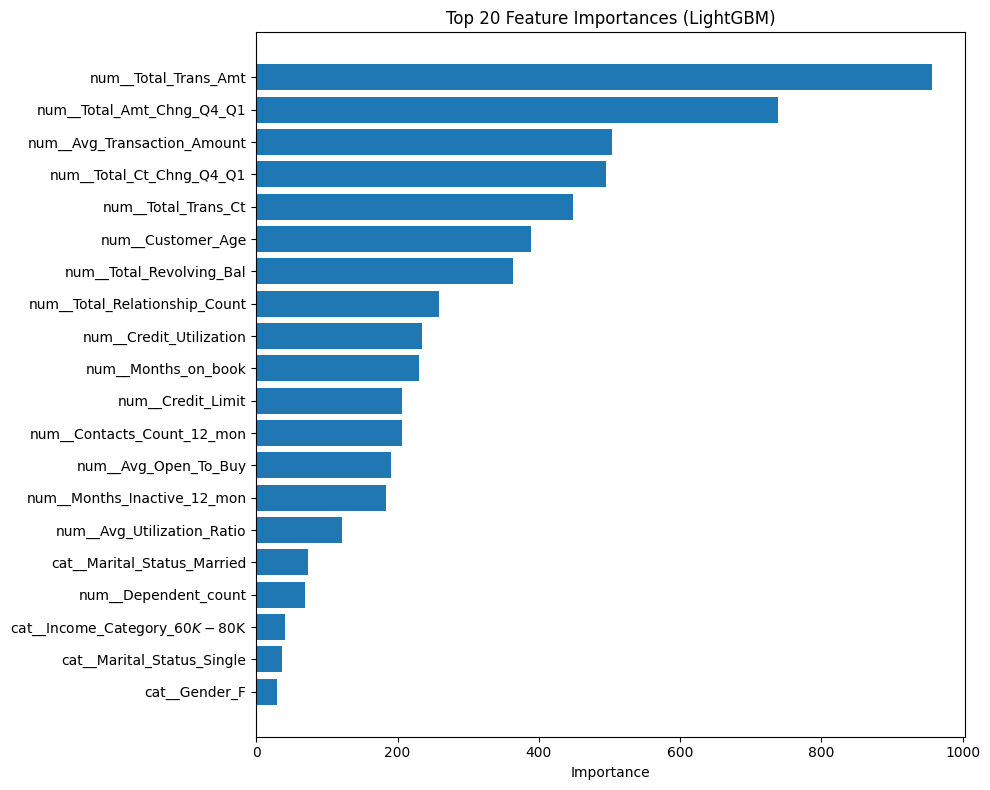

In [45]:
# 14: Feature Importance (LightGBM)
print("LightGBM Feature Importance Top 20")

feature_importance = best_lgbm_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(20)

print("\n", importance_df.to_string(index=False))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [46]:
# 15: 모델 저장
import joblib

model_to_save = {
    'Random Forest': best_rf_pipeline,
    'XGBoost': best_xgb_pipeline,
    'LightGBM': best_lgbm_pipeline,
    'Voting Ensemble': {'preprocessor': preprocessor, 'model': voting_model},
    'Stacking Ensemble': {'preprocessor': preprocessor, 'model': stacking_model}
}

best_model = model_to_save[best_model_name]

if best_model_name in ['Voting Ensemble', 'Stacking Ensemble']:
    joblib.dump(best_model, "final_churn_model_with_lgbm.pkl")
    print(f"\n{best_model_name} + Preprocessor 저장 완료")
else:
    joblib.dump(best_model, "final_churn_model_with_lgbm.pkl")
    print(f"\n{best_model_name} 저장 완료")



Stacking Ensemble + Preprocessor 저장 완료


In [47]:
# 16: 저장된 모델 로드 예제
print("저장된 모델 사용 예제")

loaded = joblib.load("final_churn_model_with_lgbm.pkl")

if isinstance(loaded, dict):
    # Voting 또는 Stacking
    loaded_preprocessor = loaded['preprocessor']
    loaded_model = loaded['model']
    X_new_processed = loaded_preprocessor.transform(X_test[:5])
    predictions = loaded_model.predict(X_new_processed)
    probabilities = loaded_model.predict_proba(X_new_processed)[:, 1]
else:
    # RF, XGB, LightGBM
    loaded_model = loaded
    predictions = loaded_model.predict(X_test[:5])
    probabilities = loaded_model.predict_proba(X_test[:5])[:, 1]

print("\n첫 5개 샘플 예측:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    status = "이탈" if pred == 1 else "유지"
    print(f"샘플 {i+1}: {status} (확률: {prob:.2%})")

print("모든 분석 완료")


저장된 모델 사용 예제

첫 5개 샘플 예측:
샘플 1: 유지 (확률: 2.61%)
샘플 2: 유지 (확률: 3.09%)
샘플 3: 유지 (확률: 39.70%)
샘플 4: 유지 (확률: 2.61%)
샘플 5: 유지 (확률: 2.45%)
모든 분석 완료


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
